In [15]:
from typing import List, Dict, Tuple, Union, Any
from tabulate import tabulate

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor

from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [47]:
def regresion_lineal(df: pd.DataFrame, x:str, y: str) -> Dict[str, float]:
    """
    Realiza una regresión lineal y devuelve los coeficientes y métricas.

    Args:
    - df (pd.DataFrame): El DataFrame.
    - x (str): El nombre de la columna independiente.
    - y (str): El nombre de la columna dependiente.

    Returns:
    - Dict[str, float]: Diccionario con los coeficientes y métricas.
    """
    x_transformado = transformar_variable(df, x)
    modelo = sm.OLS(df[y], sm.add_constant(x_transformado)).fit()
    resumen = modelo.summary2().tables[1]
    imprimir_tabla(resumen)
    coef = resumen['Coef.']
    r2 = modelo.rsquared
    r2_ajustado = modelo.rsquared_adj
    intervalo_confianza = resumen[['[0.025', '0.975]']].iloc[1]
    return {
        'pendiente': coef[0],
        'intercepcion': coef.loc['const'],
        'r2': r2,
        'r2_ajustado': r2_ajustado,
        'banda_inferior': intervalo_confianza[0],
        'banda_superior': intervalo_confianza[1]
    }

def graficar_regresion(df: pd.DataFrame, x: str, y: str, pendiente: float,
                        intercepcion: float, r2: float, r2_ajustado: float,
                        banda_inferior: float, banda_superior: float,
                        colores: Tuple[str,str]) -> None:
    """
    Grafica la regresión lineal junto con las bandas de confianza.

    Args:
    - df (pd.DataFrame): El DataFrame.
    - x (str): El nombre de la columna independiente.
    - y (str): El nombre de la columna dependiente.
    - pendiente (float): La pendiente de la regresión.
    - intercepcion (float): La intercepción de la regresión.
    - r2 (float): El coeficiente de determinación.
    - r2_ajustado (float): El coeficiente de determinación ajustado.
    - banda_inferior (float): La banda inferior del intervalo de confianza.
    - banda_superior (float): La banda superior del intervalo de confianza.
    - colores (Tuple[str, str]): Los colores para la línea de regresión y
    las bandas.
    """
    x_transformado = transformar_variable(df, x).values.reshape(-1, 1)
    df.plot(x=x,y=y, kind='scatter')
    plt.plot(df[x], pendiente * x_transformado + intercepcion, color=colores[0])
    plt.fill_between(df[x],
                    pendiente * x_transformado + banda_inferior,
                    pendiente * x_transformado + banda_superior,
                    alpha=0.2,
                    color=colores[1])

def modelo_regresion_lineal(df: pd.DataFrame, x: str, y: str) -> None:
    """
    Realiza una regresión lineal usando sklearn y grafica los resultados.

    Args:
    - df (pd.DataFrame): El DataFrame.
    - x (str): El nombre de la columna independiente.
    - y (str): El nombre de la columna dependiente.
    """
    print("Usando sklearn")
    x_transformada = transformar_variable(df, x).values.reshape(-1, 1)
    modelo_entrenado = entrenar_modelo(
        x_transformada, df[y], LinearRegression, {}
    ) # tipo: LinearRegression
    coef, intercepcion = modelo_entrenado.coef_, modelo_entrenado.intercept_
    print(f"Coeficientes: {coef} Intercepción: {intercepcion}", flush=True)

    fig, eje = crear_grafica()
    graficar_puntos(
        eje, x_transformada, df[y], params={'marker':'.', 'c':'blue'}
    )
    media = [df[y].mean() for _ in range(x_transformada.size)]
    print(f"media: {media[0]}", flush=True)
    print('Métrica R²: {:.3f}'.format(
        modelo_entrenado.score(x_transformada, df[y])
    ))
    graficar_linea(
        eje, df[x], modelo_entrenado.predict(x_transformada), color='red',
        etiqueta='Regresión entrenada'
    )
    graficar_linea(
        eje, df[x], media, color='orange', etiqueta='Media'
    )
    eje.legend(loc="upper left")
    finalizar_y_guardar(
        fig, eje, f'img/lr_{y}_{x}.png', limites_y=[min(df[y]), max(df[y])]
    )

df_por_sueldo = preparar_archivo()
imprimir_tabla(df_por_sueldo.tail(10))
# Realizar regresión lineal usando sklearn y graficar
modelo_regresion_lineal(df_por_sueldo, "Fecha", "sueldo_neto_sum")

|    | Nombre                              |   Sueldo Neto | dependencia       | Fecha      | Tipo   |
|----+-------------------------------------+---------------+-------------------+------------+--------|
|  0 | BRENDA AZENETH PICAZO GARCIA        |       8620.34 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  1 | MARIA BEATRIZ VILLAGOMEZ GONZALEZ   |       7401.35 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  2 | MARTHA ALICIA SILVA HERNANDEZ       |       5326.98 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  3 | ALBERTINA DAVILA PUENTE             |       9483.1  | RECTORIA          | 2019-12-01 | ADMIN  |
|  4 | AMELIA GRACIELA MARTINEZ DE LA PENA |       9278.1  | RECTORIA          | 2019-12-01 | ADMIN  |
|  5 | AURORA MARINA GOMEZ GUZMAN          |       5689.99 | RECTORIA          | 2019-12-01 | ADMIN  |
|  6 | CARLOS RAFAEL PALOMO ARREDONDO      |       6029.96 | RECTORIA          | 2019-12-01 | ADMIN  |
|  7 | CARMEN ALEJANDRA RAMIREZ GONZALEZ   |       5684.31 | RECTORIA    

In [25]:
def modelo_regresion_lineal_ridge(df: pd.DataFrame, x: str, y: str,
    alfas: List[int]) -> None:
    """
    Realiza una regresión lineal usando sklearn Ridge y grafica los resultados.

    Args:
    - df (pd.DataFrame): El DataFrame.
    - x (str): El nombre de la columna independiente.
    - y (str): El nombre de la columna dependiente.
    - alfas (List[int]): Lista de valores de alfa para el modelo Ridge.
    """
    print("Usando sklearn con Ridge")

    # Transformar las variables
    x_transformada = transformar_variable(df, x).values.reshape(-1, 1)
    y_transformada = df[y].values.reshape(-1, 1)
    
    # Escalar las variables
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_transformada = scaler_x.fit_transform(x_transformada)
    y_transformada = scaler_y.fit_transform(y_transformada)

    # Crear gráfica
    fig, eje = crear_grafica()
    graficar_puntos(eje, x_transformada, y_transformada,
        params={'marker': '.', 'c': 'blue'})
    
    for i, alfa in enumerate(alfas):
        # Entrenar el modelo Ridge
        modelo = entrenar_modelo(x_transformada, y_transformada, Ridge,
            {'alpha': alfa})
        
        # Realizar predicciones
        predicciones_transformadas = modelo.predict(x_transformada)
        predicciones = scaler_y.inverse_transform(predicciones_transformadas)

        # Graficar la línea de regresión
        graficar_linea(eje, df[x], predicciones, color=f"C{i}",
            etiqueta=f"alfa {alfa}")
        
        # Imprimir coeficiente e interceicón
        coef, intercepcion = modelo.coef_[0][0], modelo.intercept_[0]
        print(f"alfa: {alfa} coef: {coef} intercepción: {intercepcion}", flush=True)
    
    # Calcular y graficar la media
    media = [df[y].mean() for _ in range(x_transformada.size)]
    print(f"media: {media}", flush=True)
    graficar_linea(eje, df[x], media, color=f"C{len(alfas) + 1}",
        etiqueta='media')
    eje.legend(loc="upper left")
    finalizar_y_guardar(fig, eje, f'img/lr_ridge_{y}_{x}.png',
        limites_y=[min(df[y]), max(df[y])])

df_por_sueldo = preparar_archivo()
modelo_regresion_lineal_ridge(df_por_sueldo, "Fecha", "sueldo_neto_sum",
    alfas=[0, 1000, 10000])

|    | Nombre                              |   Sueldo Neto | dependencia       | Fecha      | Tipo   |
|----+-------------------------------------+---------------+-------------------+------------+--------|
|  0 | BRENDA AZENETH PICAZO GARCIA        |       8620.34 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  1 | MARIA BEATRIZ VILLAGOMEZ GONZALEZ   |       7401.35 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  2 | MARTHA ALICIA SILVA HERNANDEZ       |       5326.98 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  3 | ALBERTINA DAVILA PUENTE             |       9483.1  | RECTORIA          | 2019-12-01 | ADMIN  |
|  4 | AMELIA GRACIELA MARTINEZ DE LA PENA |       9278.1  | RECTORIA          | 2019-12-01 | ADMIN  |
|  5 | AURORA MARINA GOMEZ GUZMAN          |       5689.99 | RECTORIA          | 2019-12-01 | ADMIN  |
|  6 | CARLOS RAFAEL PALOMO ARREDONDO      |       6029.96 | RECTORIA          | 2019-12-01 | ADMIN  |
|  7 | CARMEN ALEJANDRA RAMIREZ GONZALEZ   |       5684.31 | RECTORIA    

In [30]:
def modelo_regresion_lineal_lasso(df: pd.DataFrame, x: str, y: str,
    alfas: List[int]) -> None:
    """
    Realiza una regresión lineal usando sklearn Lasso y grafica los resultados.

    Args:
    - df (pd.DataFrame): El DataFrame.
    - x (str): El nombre de la columna independiente.
    - y (str): El nombre de la columna dependiente.
    - alfas (List[int]): Lista de valores de alfa para el modelo Lasso.
    """
    print("usando sklearn con Lasso")

    # Transformar las variables
    x_transformada = transformar_variable(df, x).values.reshape(-1, 1)

    # Crear gráfica
    fig, eje = crear_grafica()
    graficar_puntos(eje, x_transformada, df[y],
        params={'marker': '.', 'c': 'blue'})
    
    for i, alfa in enumerate(alfas):
        # Entrenar el modelo Lasso
        modelo = entrenar_modelo(x_transformada, df[y], Lasso, {'alpha': alfa})
        
        # Realizar predicciones
        predicciones = modelo.predict(x_transformada)

        # Graficar la línea de regresión
        graficar_linea(eje, df[x], predicciones, color=f"C{i}",
            etiqueta=f"alfa {alfa}")
        
        # Imprimir coeficientes e intercepción
        coef, intercepcion = modelo.coef_[0], modelo.intercept_
        print(f"coeficientes: {coef} intercepcion: {intercepcion}", flush=True)
    
    # Calcular y graficar la media
    media = [df[y].mean() for _ in range(x_transformada.size)]
    graficar_linea(eje, df[x], media, color=f"C{len(alfas) + 1}",
        etiqueta='media')
    
    eje.legend(loc="upper left")
    finalizar_y_guardar(fig, eje, f'img/lr_lasso_{y}_{x}.png', limites_y=[min(df[y]), max(df[y])])

df_por_sueldo = preparar_archivo()
modelo_regresion_lineal_lasso(df_por_sueldo, "Fecha", "sueldo_neto_sum",
    alfas = [1, 10000000, 100000000])

|    | Nombre                              |   Sueldo Neto | dependencia       | Fecha      | Tipo   |
|----+-------------------------------------+---------------+-------------------+------------+--------|
|  0 | BRENDA AZENETH PICAZO GARCIA        |       8620.34 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  1 | MARIA BEATRIZ VILLAGOMEZ GONZALEZ   |       7401.35 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  2 | MARTHA ALICIA SILVA HERNANDEZ       |       5326.98 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  3 | ALBERTINA DAVILA PUENTE             |       9483.1  | RECTORIA          | 2019-12-01 | ADMIN  |
|  4 | AMELIA GRACIELA MARTINEZ DE LA PENA |       9278.1  | RECTORIA          | 2019-12-01 | ADMIN  |
|  5 | AURORA MARINA GOMEZ GUZMAN          |       5689.99 | RECTORIA          | 2019-12-01 | ADMIN  |
|  6 | CARLOS RAFAEL PALOMO ARREDONDO      |       6029.96 | RECTORIA          | 2019-12-01 | ADMIN  |
|  7 | CARMEN ALEJANDRA RAMIREZ GONZALEZ   |       5684.31 | RECTORIA    

In [34]:
def modelo_regresion_polinomica(df: pd.DataFrame, x: str, y: str,
        grados: List[int]) -> None:
    """
    Realiza una regresión polinómica usando sklearn y grafica los resultados.

    Args:
    - df (pd.DataFrame): El DataFrame que contiene los datos.
    - x (str): Nombre de la columna que representa la variable independiente.
    - y (str): Nombre de la columna que representa la variable dependiente.
    - grados (List[int]): Grados de los polinomios a ajustar.

    Returns:
    - None
    """
    print("Usando regresión polinómica de sklearn.")

    # Transformar la variable independiente
    x_vals = transformar_variable(df, x)
    
    # Graficar los datos
    fig, eje = crear_grafica()
    graficar_puntos(eje, x_vals, df[y], params={'marker': '.', 'c': 'blue'})

    for i, grado in enumerate(grados):
        transformador_polinomico = PolynomialFeatures(degree=grado)
        X_transformada = transformador_polinomico.fit_transform(x_vals)
        # Crear y ajustar el modelo de regresión lineal
        modelo = entrenar_modelo(X_transformada, df[y], LinearRegression, {})
        # Puntos para la línea de regresión
        y_pred = modelo.predict(X_transformada)
        graficar_linea(eje, df[x], y_pred, color=f"C{i}",
            etiqueta=f"grado {grado}")
        print(
            f'(poli grado {grado}) Coeficientes del modelo lineal (w):\n'
            f'{modelo.coef_}'
        )
        print(
            f'(poli grado {grado}) Intercepción del modelo lineal (b):\n'
            f'{modelo.intercept_:.3f}'
        )

    eje.legend(loc="upper left")
    finalizar_y_guardar(fig, eje, f'img/pr_{y}_{x}.png',
        limites_y=[min(df[y]), max(df[y])])

df_por_sueldo = preparar_archivo()
modelo_regresion_polinomica(df_por_sueldo, "Fecha", "sueldo_neto_sum",
    grados=[1, 2, 5, 8])

|    | Nombre                              |   Sueldo Neto | dependencia       | Fecha      | Tipo   |
|----+-------------------------------------+---------------+-------------------+------------+--------|
|  0 | BRENDA AZENETH PICAZO GARCIA        |       8620.34 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  1 | MARIA BEATRIZ VILLAGOMEZ GONZALEZ   |       7401.35 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  2 | MARTHA ALICIA SILVA HERNANDEZ       |       5326.98 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  3 | ALBERTINA DAVILA PUENTE             |       9483.1  | RECTORIA          | 2019-12-01 | ADMIN  |
|  4 | AMELIA GRACIELA MARTINEZ DE LA PENA |       9278.1  | RECTORIA          | 2019-12-01 | ADMIN  |
|  5 | AURORA MARINA GOMEZ GUZMAN          |       5689.99 | RECTORIA          | 2019-12-01 | ADMIN  |
|  6 | CARLOS RAFAEL PALOMO ARREDONDO      |       6029.96 | RECTORIA          | 2019-12-01 | ADMIN  |
|  7 | CARMEN ALEJANDRA RAMIREZ GONZALEZ   |       5684.31 | RECTORIA    

|       |       Coef. |         Std.Err. |        t |       P>|t| |           [0.025 |      0.975] |
|-------+-------------+------------------+----------+-------------+------------------+-------------|
| const | 1.59906e+08 |      7.58118e+06 | 21.0925  | 2.75031e-25 |      1.44646e+08 | 1.75166e+08 |
| 0     | 1.22792e+06 | 277908           |  4.41845 | 6.00196e-05 | 668523           | 1.78732e+06 |
Predicción usando modelo de regresión lineal de sklearn.
Coeficiente: 1163537.9658613487 Intercepción: 162976691.30640048
R-squared score (entrenamiento): 0.282088107
R-squared score (prueba): 0.322947859
R-squared score total model (entrenamiento): 0.278454577
R-squared score total model (prueba): 0.341959665


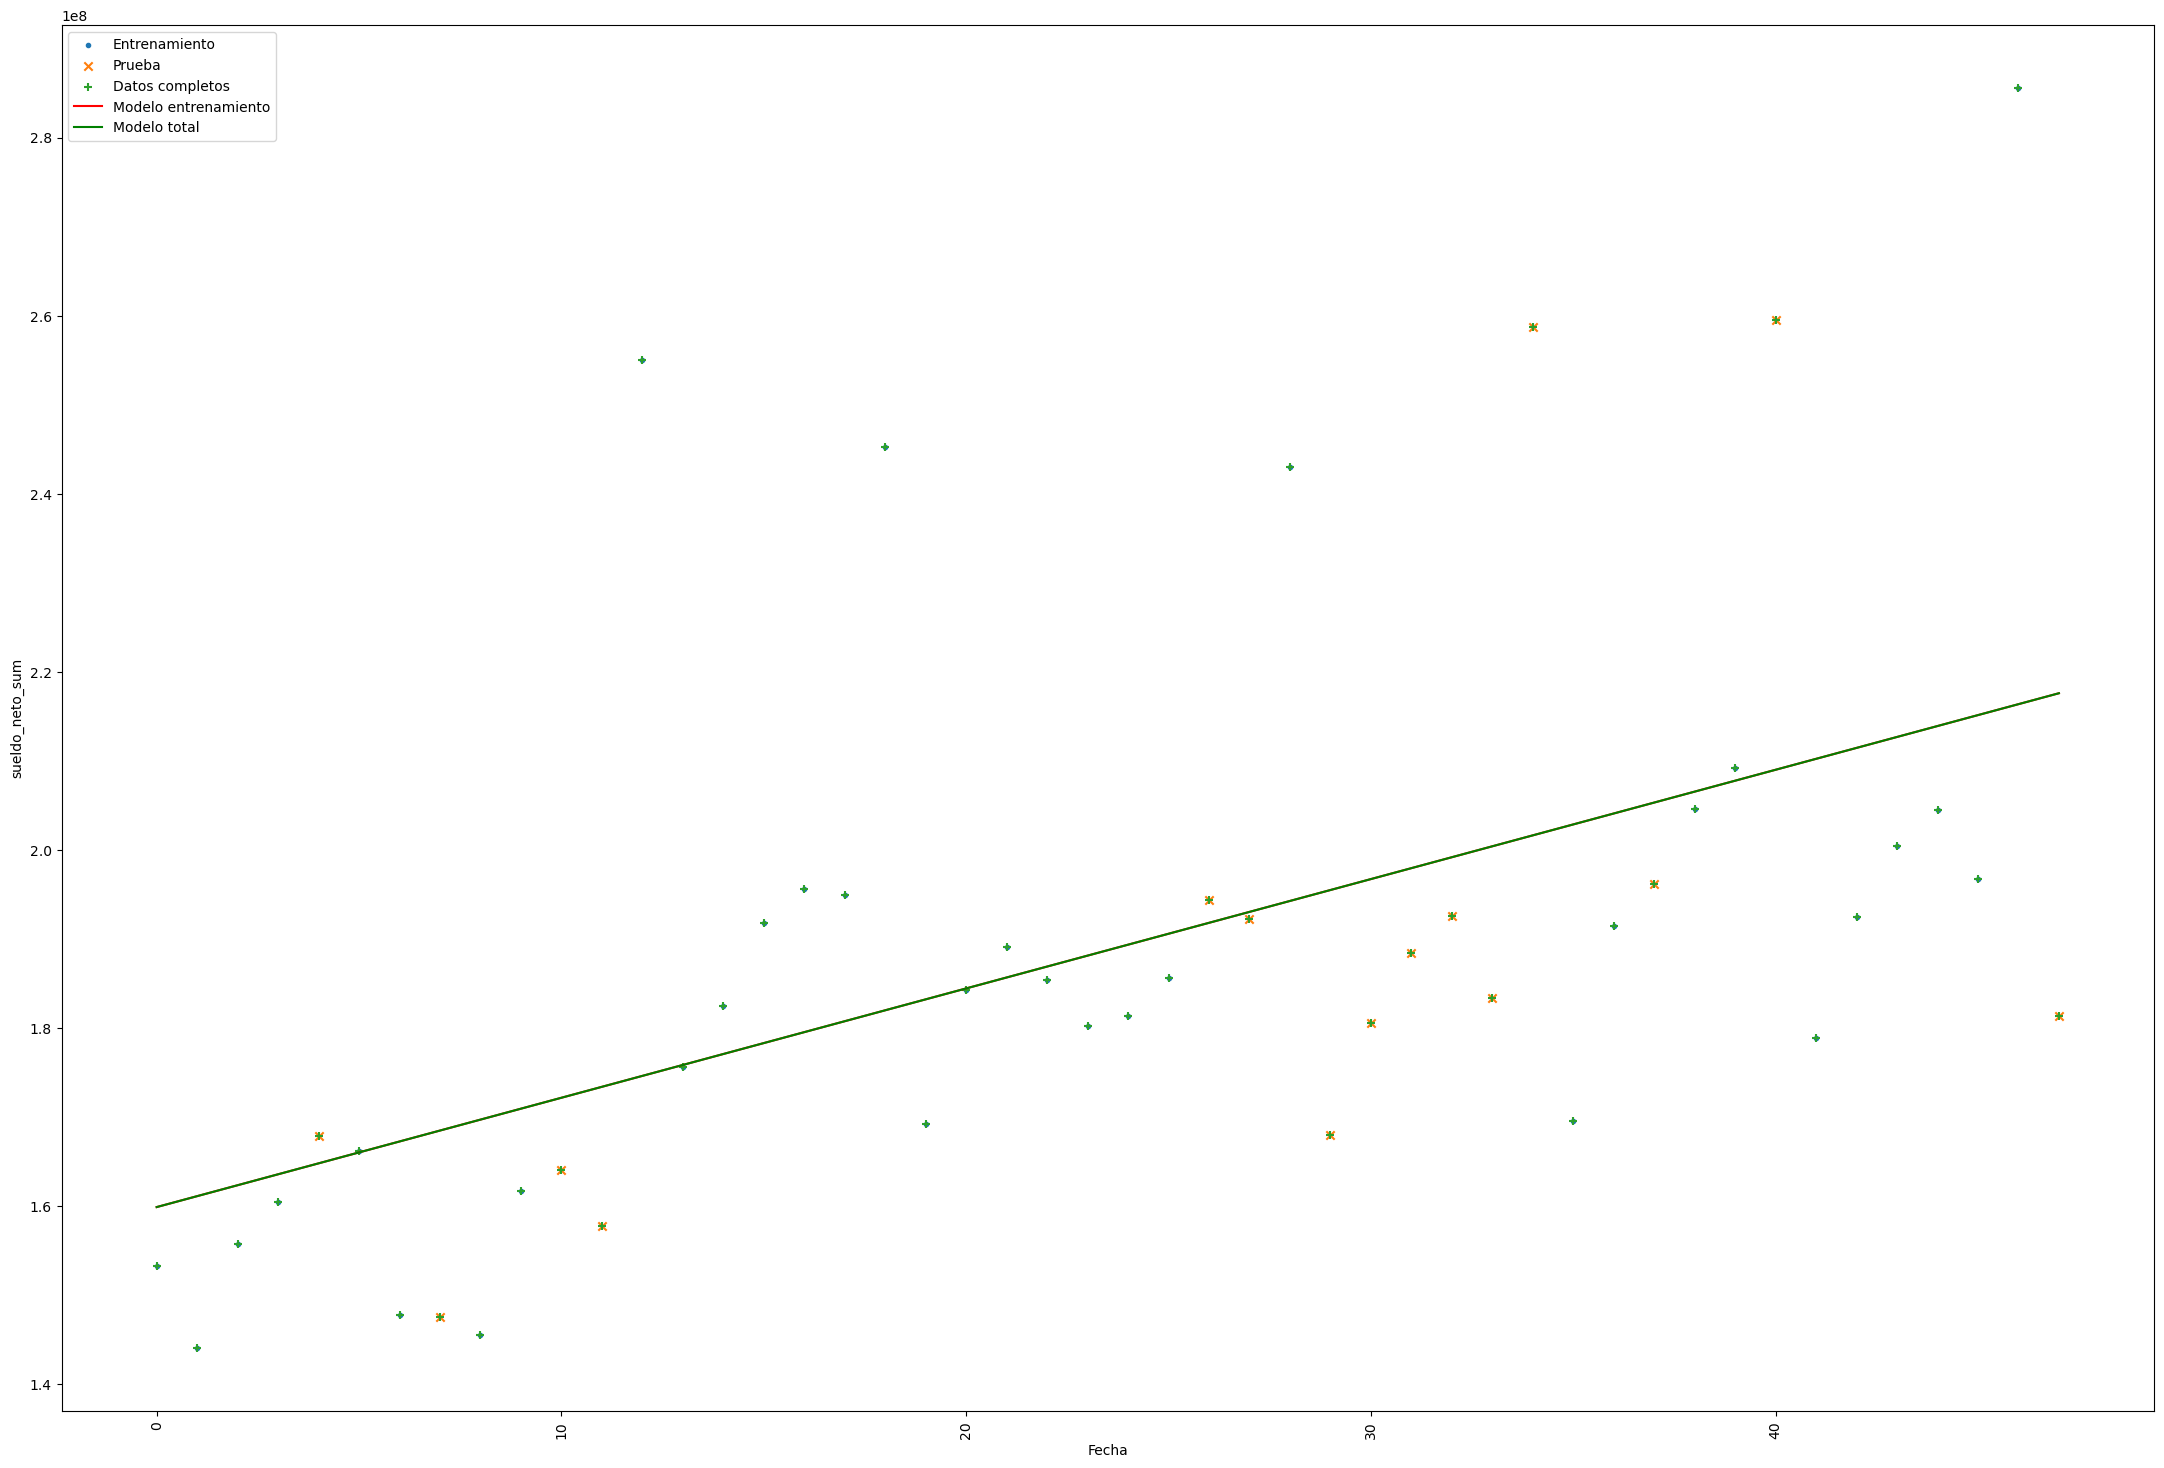

In [50]:
def predecir_regresion_lineal(df: pd.DataFrame, x: str, y: str) -> None:
    """
    Realiza una predicción usando un modelo de regresión lineal de sklearn y
    grafica los resultados.

    Args:
    - df (pd.DataFrame): El DataFrame que contiene los datos.
    - x (str): Nombre de la columna que representa la variable independiente.
    - y (str): Nombre de la columna que representa la variable dependiente.

    Returns:
    - None
    """
    print("Predicción usando modelo de regresión lineal de sklearn.")
    
    X = transformar_variable(df, x).values.reshape(-1, 1)

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, df[y], test_size=0.3, random_state=0)

    # Entrenar el modelo
    modelo = LinearRegression()
    modelo_entrenado = modelo.fit(X_train, y_train)

    # Obtener coeficientes e intercepción del modelo entrenado
    coef, intercept = modelo_entrenado.coef_[0], modelo_entrenado.intercept_
    print(f"Coeficiente: {coef} Intercepción: {intercept}")
    
    # Evaluar el modelo en el conjunto de entrenamiento y prueba
    print('R-squared score (entrenamiento): {:.9f}'.format(
        modelo_entrenado.score(X_train, y_train)))
    print('R-squared score (prueba): {:.9f}'.format(
        modelo_entrenado.score(X_test, y_test)))
    
    # Entrenar modelo con todos los datos
    total_model = modelo.fit(X, df[y])
    total_coef, total_intercept = total_model.coef_[0], total_model.intercept_

    # Métricas del modelo total
    print('R-squared score total model (entrenamiento): {:.9f}'.format(
        total_model.score(X_train, y_train)))
    print('R-squared score total model (prueba): {:.9f}'.format(
        total_model.score(X_test, y_test)))

    # Graficar los datos y las líneas de regresión
    plt.scatter(X_train, y_train, marker='.', label='Entrenamiento')
    plt.scatter(X_test, y_test, marker='x', label='Prueba')
    plt.scatter(X, df[y], marker='+', label='Datos completos')
    plt.plot(X, modelo_entrenado.predict(X),
        color='red', label='Modelo entrenamiento')
    plt.plot(X, total_model.predict(X), color='green', label='Modelo total')
    
    # Configurar la gráfica
    plt.xlabel(x)
    plt.ylabel(y)
    plt.xticks(rotation=90)
    plt.legend()
    plt.gcf().set_size_inches(27,18)
    plt.savefig(f'img/lr2_{y}_{x}.png')
    plt.show()

# Realizar regresión lineal
resultados_regresion = regresion_lineal(df_por_sueldo,
                                        "Fecha", "sueldo_neto_sum")

# Graficar resultados
# graficar_regresion(df=df_por_sueldo, x="Fecha", y="sueldo_neto_sum",
#                     colores=('red', 'orange'), **resultados_regresion)

# plt.xticks(rotation=90)
# plt.savefig('img/lr_sueldo_mensual_Fecha_m.png')
# plt.close()

predecir_regresion_lineal(df_por_sueldo, "Fecha", "sueldo_neto_sum")

In [38]:
def modelo_regresion_polinomica_ridge(df: pd.DataFrame, x: str, y: str,
        grados: List[int], alfas: List[float]) -> None:
    """
    Realiza regresiones polinómicas usando el modelo de Ridge de sklearn y
    grafica los resultados.

    Args:
    - df (pd.DataFrame): El DataFrame que contiene los datos.
    - x (str): Nombre de la columna que representa la variable independiente.
    - y (str): Nombre de la columna que representa la variable dependiente.
    - grados (List[int]): Grados de los polinomios a ajustar.
    - alfas (List[float]): Parámetros de regularización Ridge.

    Returns:
    - None
    """
    print("Usando regresión polinómica Ridge de sklearn.")

    # Transformar la variable independiente
    x_vals = transformar_variable(df, x)
    
    # Graficar los datos
    fig, eje = crear_grafica()
    graficar_puntos(eje, x_vals, df[y], params={'marker': '.', 'c': 'blue'})

    for i, grado in enumerate(grados):
        for j, alfa in enumerate(alfas):
            transformador_polinomico = PolynomialFeatures(degree=grado)
            X_transformada = transformador_polinomico.fit_transform(x_vals)
            
            # Crear y ajustar el modelo de regresión Ridge
            modelo = entrenar_modelo(X_transformada, df[y], Ridge, {'alpha': alfa})
            
            # Realizar predicciones
            y_pred = modelo.predict(X_transformada)

            # Graficar la línea de regresión
            color_number = i * len(alfas) + j
            graficar_linea(eje, df[x], y_pred, color=f"C{i}",
                etiqueta=f"grado {grado} alfa {alfa}")
            
            # Imprimir coeficientes e intercepción
            print(
                f'(poli grado {grado}) Coeficientes del modelo lineal (w):\n'
                f'{modelo.coef_}'
            )
            print(
                f'(poli grado {grado}) Intercepción del modelo lineal (b):\n'
                f'{modelo.intercept_:.3f}'
            )

    eje.legend(loc="upper left")
    finalizar_y_guardar(fig, eje, f'img/pr_ridge_{y}_{x}.png',
        limites_y=[min(df[y]), max(df[y])])

df_por_sueldo = preparar_archivo()
modelo_regresion_polinomica_ridge(df_por_sueldo, "Fecha", "sueldo_neto_sum",
    grados=[8], alfas=[1, 100, 1000])

|    | Nombre                              |   Sueldo Neto | dependencia       | Fecha      | Tipo   |
|----+-------------------------------------+---------------+-------------------+------------+--------|
|  0 | BRENDA AZENETH PICAZO GARCIA        |       8620.34 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  1 | MARIA BEATRIZ VILLAGOMEZ GONZALEZ   |       7401.35 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  2 | MARTHA ALICIA SILVA HERNANDEZ       |       5326.98 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  3 | ALBERTINA DAVILA PUENTE             |       9483.1  | RECTORIA          | 2019-12-01 | ADMIN  |
|  4 | AMELIA GRACIELA MARTINEZ DE LA PENA |       9278.1  | RECTORIA          | 2019-12-01 | ADMIN  |
|  5 | AURORA MARINA GOMEZ GUZMAN          |       5689.99 | RECTORIA          | 2019-12-01 | ADMIN  |
|  6 | CARLOS RAFAEL PALOMO ARREDONDO      |       6029.96 | RECTORIA          | 2019-12-01 | ADMIN  |
|  7 | CARMEN ALEJANDRA RAMIREZ GONZALEZ   |       5684.31 | RECTORIA    

/usr/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.61509e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.61509e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.96398e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [42]:
def modelo_regresion_polinomica_lasso(df: pd.DataFrame, x: str, y: str,
        grados: List[int], alfas: List[float]) -> None:
    """
    Realiza regresiones polinómicas usando el modelo de Lasso de sklearn y
    grafica los resultados.

    Args:
    - df (pd.DataFrame): El DataFrame que contiene los datos.
    - x (str): Nombre de la columna que representa la variable independiente.
    - y (str): Nombre de la columna que representa la variable dependiente.
    - grados (List[int]): Grados de los polinomios a ajustar.
    - alfas (List[float]): Parámetros de regularización de Lasso.

    Returns:
    - None
    """
    print("Usando regresión polinómica Lasso de sklearn.")

    # Transformar la variable independiente
    x_vals = transformar_variable(df, x)
    
    # Graficar los datos
    fig, eje = crear_grafica()
    graficar_puntos(eje, x_vals, df[y], params={'marker': '.', 'c': 'blue'})

    for i, grado in enumerate(grados):
        for j, alfa in enumerate(alfas):
            transformador_polinomico = PolynomialFeatures(degree=grado)
            X_transformada = transformador_polinomico.fit_transform(x_vals)
            
            # Crear y ajustar el modelo de regresión Lasso
            modelo = entrenar_modelo(X_transformada, df[y], Lasso, {'alpha': alfa})
            
            # Realizar predicciones
            y_pred = modelo.predict(X_transformada)

            # Graficar la línea de regresión
            color_number = i * len(alfas) + j
            graficar_linea(eje, df[x], y_pred, color=f"C{i}",
                etiqueta=f"grado {grado} alfa {alfa}")
            
            # Imprimir coeficientes e intercepción
            print(
                f'(poli grado {grado}) Coeficientes del modelo lineal (w):\n'
                f'{modelo.coef_}'
            )
            print(
                f'(poli grado {grado}) Intercepción del modelo lineal (b):\n'
                f'{modelo.intercept_:.3f}'
            )

    eje.legend(loc="upper left")
    finalizar_y_guardar(fig, eje, f'img/pr_lasso_{y}_{x}.png',
        limites_y=[min(df[y]), max(df[y])])

df_por_sueldo = preparar_archivo()
modelo_regresion_polinomica_lasso(df_por_sueldo, "Fecha", "sueldo_neto_sum",
    grados=[8], alfas=[0.01, 0.1, 1, 10, 100])

|    | Nombre                              |   Sueldo Neto | dependencia       | Fecha      | Tipo   |
|----+-------------------------------------+---------------+-------------------+------------+--------|
|  0 | BRENDA AZENETH PICAZO GARCIA        |       8620.34 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  1 | MARIA BEATRIZ VILLAGOMEZ GONZALEZ   |       7401.35 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  2 | MARTHA ALICIA SILVA HERNANDEZ       |       5326.98 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  3 | ALBERTINA DAVILA PUENTE             |       9483.1  | RECTORIA          | 2019-12-01 | ADMIN  |
|  4 | AMELIA GRACIELA MARTINEZ DE LA PENA |       9278.1  | RECTORIA          | 2019-12-01 | ADMIN  |
|  5 | AURORA MARINA GOMEZ GUZMAN          |       5689.99 | RECTORIA          | 2019-12-01 | ADMIN  |
|  6 | CARLOS RAFAEL PALOMO ARREDONDO      |       6029.96 | RECTORIA          | 2019-12-01 | ADMIN  |
|  7 | CARMEN ALEJANDRA RAMIREZ GONZALEZ   |       5684.31 | RECTORIA    

/usr/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.553e+16, tolerance: 4.662e+12
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.553e+16, tolerance: 4.662e+12
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.553e+16, tolerance: 4.662e+12
  model = cd_f